# Create Gaussian random fields with lya survey geometry to compute $C_{\ell}(k)$
- [x] generate GRFs with Lya bias and beta
- [x] draw skewers through box
- [x] FFT each skewer and construct $\delta_{2D}$ matrix
    - [x] do discrete version where multiplication of $\exp(i\mathbf(k)\mathbf{\chi})$
- [x] matrix of shape: (N_qso x N_kbins), so that in row i: ($\delta_F(k_0), \dots,\delta_F(k_N)$)
- [x] compute $$a_{\ell m}(\mathbf{k}) = \sum_j^{N_q} \delta_{2D}(x,y,z,k_i)Y_{\ell m}^{\ast}(x,y,j)$$
- [x] compute $$\hat{C}_{\ell}(k_i) = \texttt{hp.alm2cl}(a_lm(k_i))$$
- [ ] compute theory Eq. 2.13 in draft

In [3]:
%matplotlib inline
import numpy as np
from matplotlib_params_file import *
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, legendre
from scipy.integrate import simps
from numba import jit
import multiprocessing as mp
import healpy as hp
from scipy.linalg import dft

#camb
import camb 
from camb import model, initialpower

# GRFs
import GRF_class as my_GRF

_fastmath False
_parallel True
_nopython False


## create GRFs
- set `add_rsd=True' if you want to add RSD

In [99]:
GRF = my_GRF.PowerSpectrumGenerator(add_rsd=False)

Fundamental mode k_f= 0.004553032831289555
max mode k_f= 2.0188375532346075
Nyquist frequency: 1.165576404810126
ratio of Nyquist to fundamental freq 256.0
ratio of max to Nyquist freq 1.7320508075688774
beta 0.0
bias 1.0
RSD: False
get power spectrum from CAMB
define k grid
compute amplitudes
Include anisotropies False
compute mu = k_los / |k|
bias 1.0
beta 0.0
Transforming amplitudes to density field


In [5]:
# compute power spectrum with mode counting in spherical shells
k_eff, p0_hat, p2_hat, p4_hat, counts, totcounts = GRF.compute_power_spectrum()
# theory power spectrum anisotropic
p0, p2, p4 = GRF.get_multipoles()


compute power spectrum


134217726.0
134217728
134217728


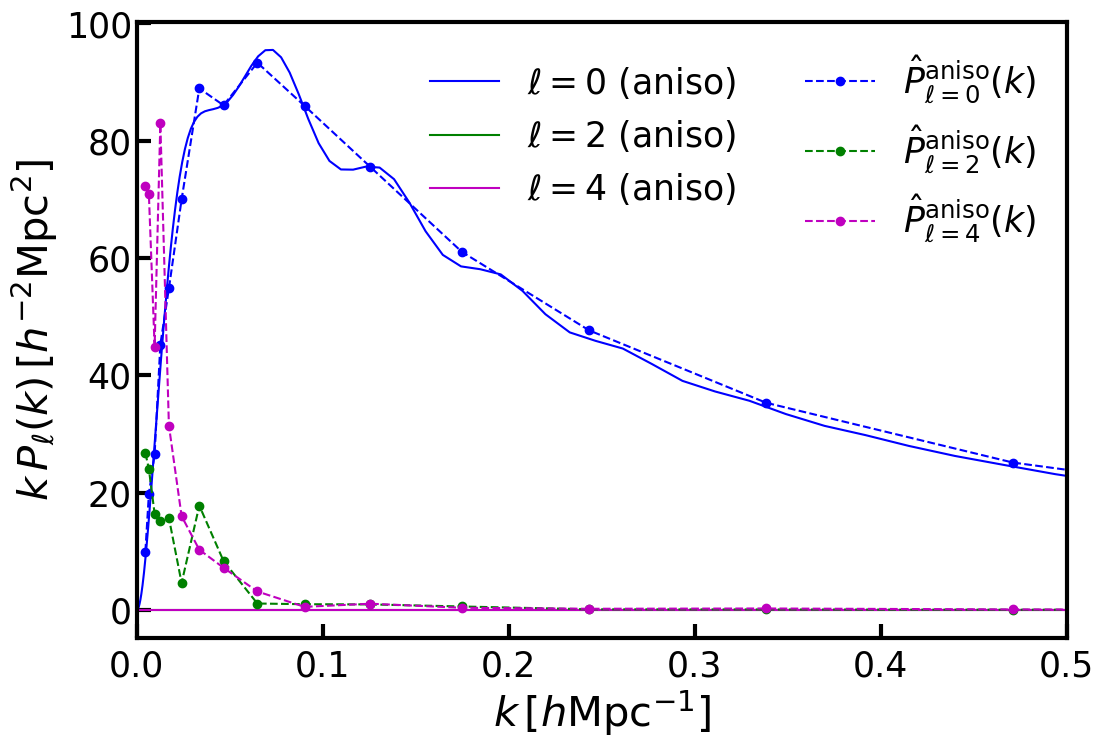

In [6]:
### compare theory to measurement
plt.figure()
plt.plot(GRF.kh_lin, GRF.kh_lin*p0, 'b-', label=r'$\ell=0$ (aniso)')
plt.plot(GRF.kh_lin, GRF.kh_lin*p2, 'g-', label=r'$\ell=2$ (aniso)')
plt.plot(GRF.kh_lin, GRF.kh_lin*p4, 'm-', label=r'$\ell=4$ (aniso)')
plt.plot(k_eff, k_eff*p0_hat, 'bo--',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff, k_eff*abs(p2_hat), 'go--',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff, k_eff*abs(p4_hat), 'mo--',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')
plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
plt.legend(ncol=2);plt.xlim(0., 0.5);
#plt.ylim(0., 320)
plt.show()


## Sample skewers
- Note that we apply a shift along the z axis. This is necessary to ensure that the $\mu$ angle is with respect to the z-axis
- computes $\mu$ with respect to the combined line-of-sight; $(\vec{r}_i+\vec{r}_j)/2$

In [7]:
def process_skewers(N, L, dens, shift = 5e+3):
    """
    Process skewers for a 3D grid and compute related fields.

    Parameters:
    N (int): The number of points along each axis of the 3D grid.
    L (float): The length of the side of the 3D box.
    dens (np.array): The density field of the 3D grid.
    shift (float): The displacement value for the z-coordinates.

    Returns:
    tuple: Processed coordinates (all_x, all_y, all_z), all_w_rand, all_w_gal, and all_hpx.
    """
    # Generate 3D meshgrid coordinates
    coords = np.meshgrid(*[np.linspace(0, L, N) for _ in range(3)])

    # Generate skewers
    Nskew = int(1.3e+5)
    np.random.seed(100)
    inds = np.unique(np.random.randint(0, N, size=(Nskew, 2)), axis=0)
    Nskew = len(inds)
    print("N_skew = %d / %d" % (Nskew, N**2))

    # Compute density skewers and add 1
    dens_lya = dens[inds[:,0], inds[:,1], :] 
    skewer_field = dens_lya + 1.

    # Displace the box in the z-direction
    print("Displacing box by %.3e" % shift)
    tmp_all_x = coords[0][inds[:,0], inds[:,1], :]  # + shift
    tmp_all_y = coords[1][inds[:,0], inds[:,1], :]  # + shift
    tmp_all_z = coords[2][inds[:,0], inds[:,1], :] + shift

    # Swap coordinates
    all_x = tmp_all_z.copy()
    all_y = tmp_all_y.copy()
    all_z = tmp_all_x.copy()

    # Define mask (in draft: K_j(chi))
    all_w_rand = np.ones_like(all_x, dtype='float')
    
    # Define delta (in draft: delta_F(chi))
    all_w_gal = np.asarray(skewer_field, dtype='float')

    return all_x, all_y, all_z, all_w_rand, all_w_gal

In [8]:
all_x, all_y, all_z, all_w_rand, all_w_gal = process_skewers(GRF.N, GRF.L, dens=GRF.dens)

N_skew = 102498 / 262144
Displacing box by 5.000e+03


In [9]:
Nskew = all_x.shape[0]

In [10]:
def compute_theta_phi_skewer_start(x,y,z):
    # only compute the Theta, Phi angle for the *first* pixel of the Lya skewer

    xsq = x ** 2.
    ysq = y ** 2.

    s = (xsq + ysq) ** 0.5

    # convert to degrees
    phi = np.arctan2(y, x)
    theta = np.arctan2(s, z)
   
    return theta, phi

In [11]:
all_theta, all_phi = compute_theta_phi_skewer_start(all_x[:,0], all_y[:,0], all_z[:,0])
chi_grid = all_x[0,:]

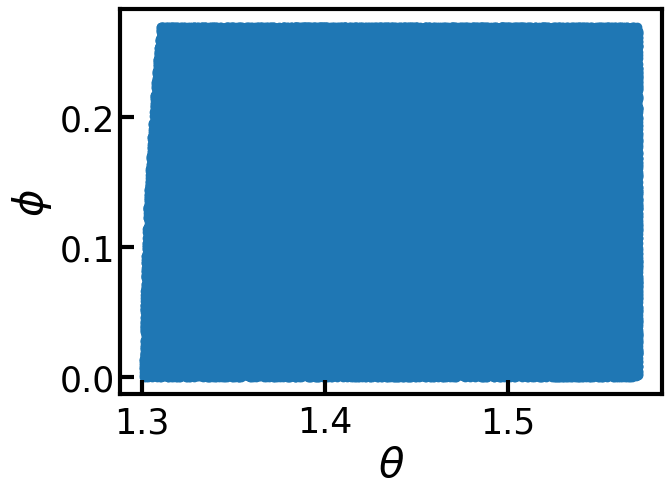

In [12]:
# theta, phi positions of skewers in the sky 
plt.figure(figsize=(7,5));plt.scatter(all_theta, all_phi);plt.xlabel(r'$\theta$');plt.ylabel(r'$\phi$');plt.show()

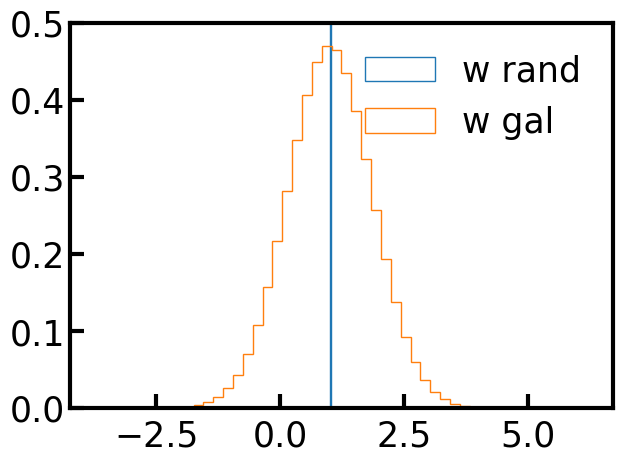

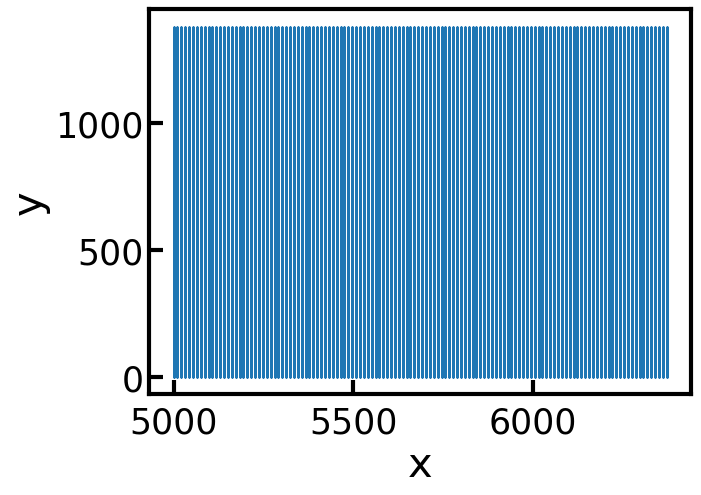

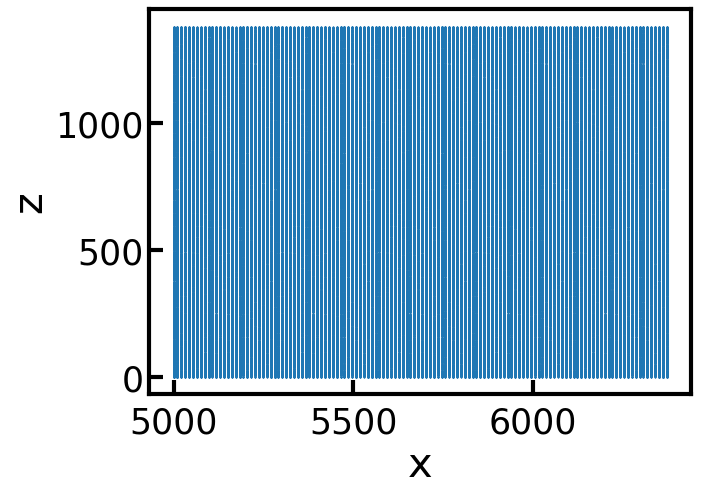

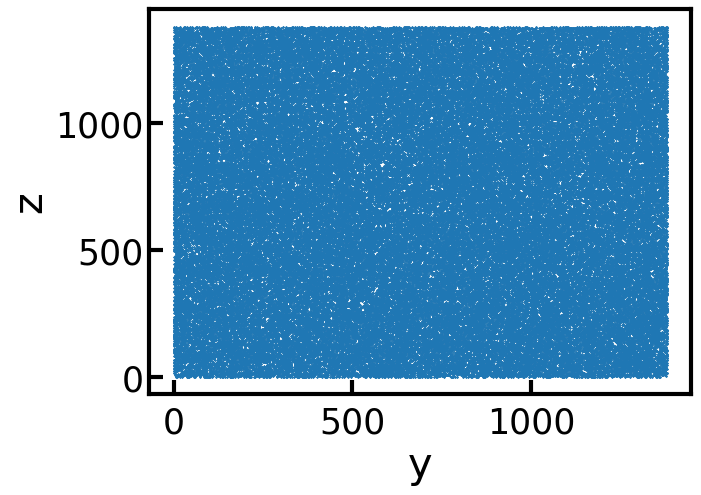

In [13]:
### Plot distribution of weights
plt.figure(figsize=(7,5));
plt.hist(all_w_rand.ravel(),density=True,histtype='step', bins=50, label='w rand');
plt.hist(all_w_gal.ravel(),density=True, histtype='step',bins=50, label='w gal');
plt.ylim(0., 0.5);plt.legend()
plt.show()

#### Visually check if skewers are taken through box
plt.figure(figsize=(7,5));plt.scatter(all_x.ravel()[::100],all_y.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('y');plt.show()
plt.figure(figsize=(7,5));plt.scatter(all_x.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('z');plt.show()
plt.figure(figsize=(7,5));plt.scatter(all_y.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('y');plt.ylabel('z');plt.show()

## compute discrete Fourier transform of matrix $N_{qso} \times N_{pix}$

- compute $\delta_{2D}(\hat{n}_j;k)$ for $\delta_{3D}=\delta_F(\chi\hat{n}_j)$ along each QSO sightline, $\hat{n}_j$, using FFTs [or as matrix-vector multiply of $\exp[ik\chi]$] with $K_j(\chi)\delta_F(\chi)$.
- Since the DESI QSO spectra all share a common wavelength grid, the ``matrix'' can be computed once.  It is convenient to store the real and imaginary parts separately.  
- same procedure on $K_j(\chi)$ not weighted by $\delta_F$ gives $\widetilde{K}_j(k)$.

- use $\delta_{2D}(\hat{n}_j;k)$ as weights for each QSO
- perform a spherical harmonic transform for each $k$
- For $\ell_{\rm max}=10^3$ and $10^6$ QSOs this takes a few seconds for each of the real and imaginary parts for each $k$.  
- Squaring the results and averaging over $m$ gives $C_\ell(k)$, which can be binned into bins of $\ell$ and normalized as desired.  

- compute the window matrix.  This is independent of the data, depending only upon the chosen weights, $K_j(\chi)$, and the QSO positions, $\hat{n}_j$.  If the matrix $\hat{n}_j\cdot\hat{n}_k$ is pre-computed, the sum over $\lambda$ can be done with recurrence relations and the final sum over $jk$ is a matrix product and trace though the final object depends upon $\ell$ (normally binned), $L$ and $k-k'$ and so can be large.  For very large numbers of sightlines, the sum over $j$ can be done in batches using the same procedure.


In [14]:
# # simple sin test case 
# N_sin=1000
# sin_grid = np.linspace(0, 10*np.pi, N_sin)
# sin_vals = np.sin(sin_grid)
# dx=np.diff(sin_grid)[0]
# k_arr = np.fft.fftfreq(N_sin, d=dx)
# FT_mat = np.exp(-2.*np.pi*1j * np.outer(sin_grid, k_arr))
# FT_sin = np.dot(sin_vals, FT_mat)
# fft_sin = np.fft.fft(sin_vals)
# DFT_mat = dft(len(sin_grid))
# DFT_sin = np.dot(sin_vals, DFT_mat)

# plt.figure(figsize=(7,4))
# plt.plot(k_arr, fft_sin, label='np.fft.fft')
# plt.plot(k_arr, FT_sin,ls='--', label='my FT')
# plt.plot(k_arr, DFT_sin,ls=':', label='DFT')
# plt.xlim(0.0, 0.5)
# plt.axvline(1/(2*np.pi), c='k')
# plt.legend();plt.show()

In [15]:
def compute_dft_scipy(chi_grid, mask, delta):
    # Ensure that chi_grid has a uniform step size
    diffs = np.diff(chi_grid)
    dx = diffs[0]
    assert np.allclose(diffs, dx), "Not all values in np.diff(chi_grid) are identical."

    # Number of points
    N = len(chi_grid)

    # Define k-array for Fourier transform
    k_arr = np.fft.fftfreq(N, d=dx)

    FT_mat = dft(N)
    # Perform the DFT using matrix multiplication
    FT_mask  = np.dot(mask, FT_mat)
    FT_delta = np.dot(delta, FT_mat)
    return k_arr, np.real(FT_mask), np.real(FT_delta)

In [16]:
def compute_dft(chi_grid, mask, delta):
    """
    Compute the Discrete Fourier Transform

    Parameters:
    chi_grid (np.array): Input array representing the chi grid.
    mask (np.array): Input array of mask values.
    delta (np.array): Input array of delta values for the Lya forest.

    Returns:
    tuple: The DFT results of mask and delta.
    """
    # Ensure that chi_grid has a uniform step size
    diffs = np.diff(chi_grid)
    dx = diffs[0]
    assert np.allclose(diffs, dx), "Not all values in np.diff(chi_grid) are identical."

    # Number of points
    N = len(chi_grid)

    # Define k-array for Fourier transform
    k_arr = np.fft.fftfreq(N, d=dx)

    # Define the Fourier matrix (Vandermonde matrix)
    # FT definition using -2*pi
    FT_mat = np.exp(-2.j * np.pi * np.outer(chi_grid, k_arr))

    # Perform the DFT using matrix multiplication
    FT_mask = np.dot(mask, FT_mat)
    FT_delta = np.dot(delta, FT_mat)
    return k_arr, np.real(FT_mask), np.real(FT_delta)
#k_arr, FT_mask, FT_delta = compute_dft(chi_grid, all_w_rand, all_w_gal)

In [17]:
k_arr, FT_mask, FT_delta = compute_dft_scipy(chi_grid, all_w_rand, all_w_gal)

### use directSHT to compute $C_{ell}$

In [18]:
import sys
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht-lya/')
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

env: JAX_ENABLE_X64=True
gpu


In [19]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 500 , Nx= 1000  and xmax= 0.625
For randoms, Direct SHT has Nl= 564 , Nx= 1000  and xmax= 0.625


In [20]:
tdata,pdata,wdata = all_theta, all_phi, FT_delta
trand,prand,wrand = all_theta, all_phi, FT_mask

In [21]:
print(wrand.shape)
print(prand.shape)

(102498, 512)
(102498,)


In [22]:
# define index for calculation 
k_idx = 0
# To Do: do this in a loop

In [23]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand[:,k_idx])
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
#sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl)# - sn

Sorting & digitizing took  0.4620227813720703  seconds.
Reshaping took  0.3872818946838379  seconds.
Precomputing vs took  0.6749401092529297  seconds.
Computing alm's took  1.600987195968628  seconds.


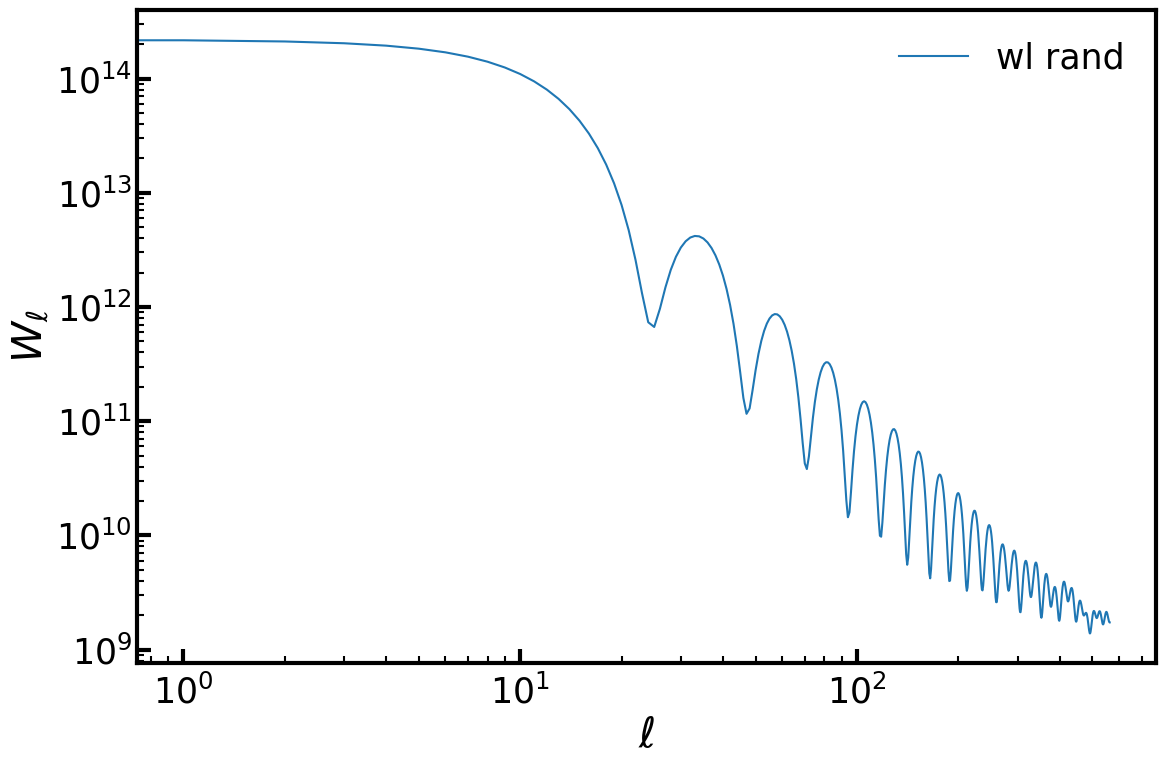

In [24]:
plt.loglog(wl   ,label='wl rand')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
plt.savefig('harmonic_window.pdf')

## compute Wigner3j

In [41]:
# if I want to use SHT for the Wigner3j computation
try:
    # Wigner3j code
    from timeit import default_timer as timer
    import fast_Wigner3j as Wigner3j
    print('use rmvd2 Wigner3j computation')

    #iitialize class
    couple_mat = Wigner3j.CoupleMat(Nl+buffer_ells, wl)
    # time execution code
    start = timer()
    coupling_matrix = couple_mat.compute_matrix()
    end = timer()

    # print elapsed time
    print('elapsed time {:1.5f}s'.format(end - start), flush=True)

    %time MD = MaskDeconvolution(Nl+buffer_ells,wl,precomputed_Wigner=coupling_matrix)
except:
    print('use SHT native Wigner3j computation')
    %time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

use rmvd2 Wigner3j computation
start computation Wigner 3j symbols
elapsed time 0.00951s
Precomputing Wigner 3j symbols...
read in Wigner 3j matrix
CPU times: user 1.53 ms, sys: 0 ns, total: 1.53 ms
Wall time: 341 µs

Row sums of Mbl:
[1.0006288  1.00038333 1.00038149 1.00040437 1.0004925  1.00047039
 1.00051257 1.00055444 1.00060512 1.000651   1.00077623 1.00097036
 1.00129562 1.00143222 1.00555634 0.98570271 1.16283557]


### plot coupling matrix and window func

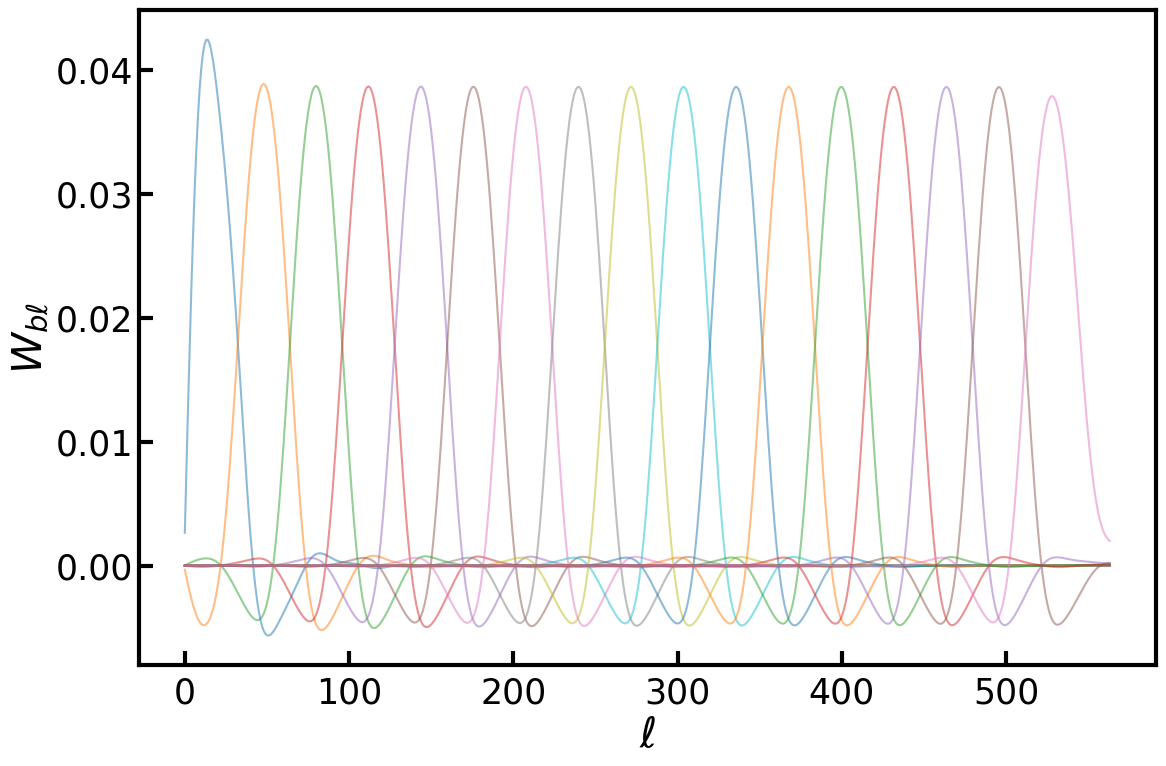

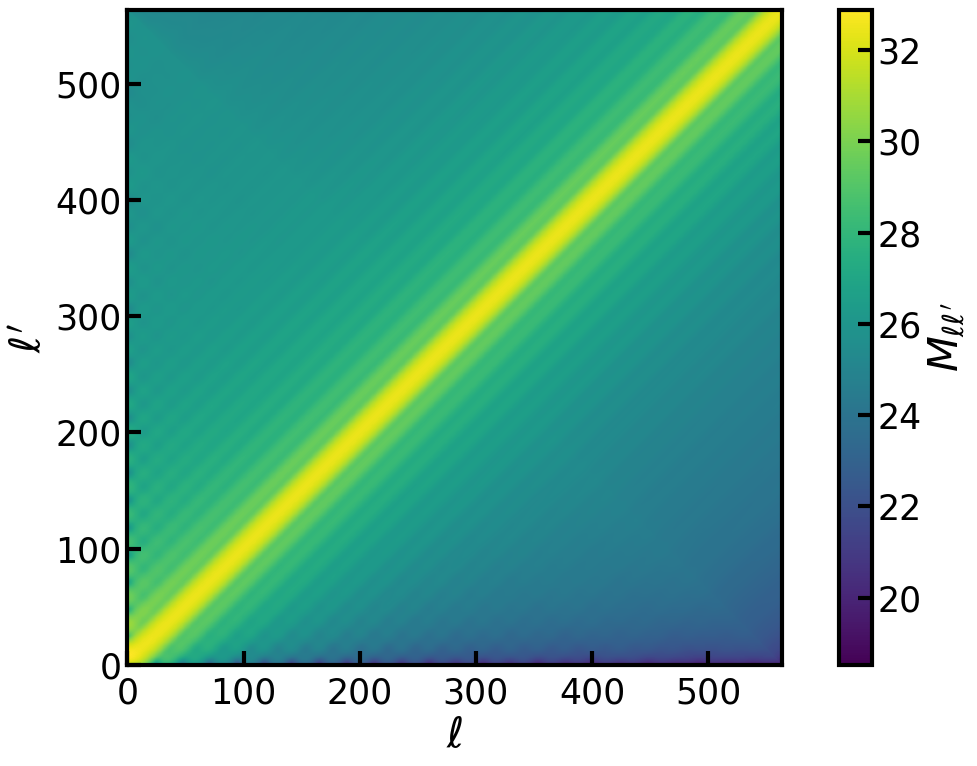

In [28]:
# Plot the matrix:
fig,ax = plt.subplots(1,1)
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
#ax.set_ylim(-0.07, 0.07)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()
plt.savefig('./plots/harmonic_wbl.pdf', bbox_inches='tight')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1)
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
im = ax.imshow(mode_coupling.T,origin='lower')
ax.set_xlabel(r'$\ell$')
fig.colorbar(im, label=r'$M_{\ell \ell^\prime}$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
plt.savefig('./plots/harmonic_mll.pdf', bbox_inches='tight')

### compute $C_{\ell}(k)$ for different values of $k$

In [29]:
cl_k = []
for k_idx in np.arange(0, 512, 200):
    hdat = sht(tdata,pdata,wdata[:,k_idx])
    # Do the same for the randoms.
    hran = sht(trand,prand,wrand[:,k_idx])
    # and for the difference of data and randoms:
    hdif = hp.alm2cl(hdat-hran)
    cl_k.append(hdif)
cl_k = np.stack(cl_k)

Sorting & digitizing took  0.008429527282714844  seconds.


Reshaping took  0.04146623611450195  seconds.
Precomputing vs took  0.3312227725982666  seconds.
Computing alm's took  1.245917558670044  seconds.
Sorting & digitizing took  0.008101224899291992  seconds.
Reshaping took  0.032430410385131836  seconds.
Precomputing vs took  0.03487539291381836  seconds.
Computing alm's took  0.9377281665802002  seconds.
Sorting & digitizing took  0.0074443817138671875  seconds.
Reshaping took  0.03205442428588867  seconds.
Precomputing vs took  0.03460121154785156  seconds.
Computing alm's took  0.9359226226806641  seconds.
Sorting & digitizing took  0.008140802383422852  seconds.
Reshaping took  0.03129100799560547  seconds.
Precomputing vs took  0.03393912315368652  seconds.
Computing alm's took  0.946998119354248  seconds.
Sorting & digitizing took  0.0083160400390625  seconds.
Reshaping took  0.03159904479980469  seconds.
Precomputing vs took  0.034345149993896484  seconds.
Computing alm's took  0.9282803535461426  seconds.
Sorting & digitizing took

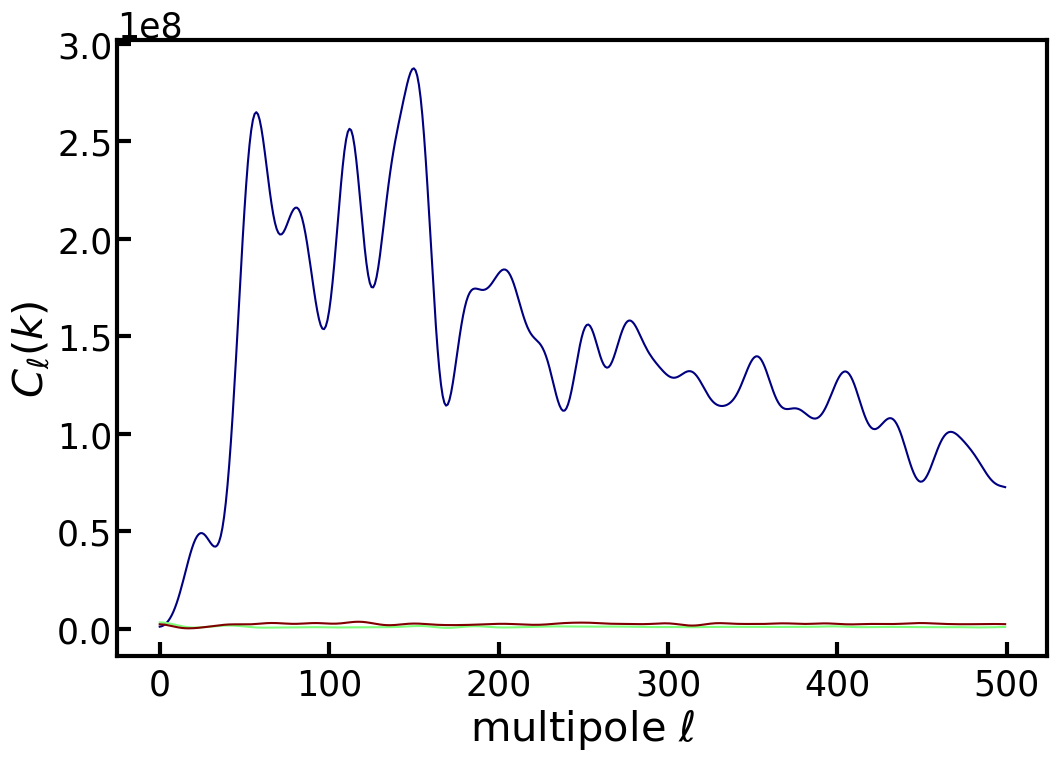

In [30]:
n = len(cl_k)
colors = plt.cm.jet(np.linspace(0,1,n))

for k_idx in range(len(cl_k)):
    plt.plot(np.arange(sht.Nell), cl_k[k_idx],color=colors[k_idx])

plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}(k)$')
plt.show()

In [31]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata[:,k_idx])
# Do the same for the randoms.
hran = sht(trand,prand,wrand[:,k_idx])
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
#print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))

Sorting & digitizing took  0.008240461349487305  seconds.


Reshaping took  0.03338932991027832  seconds.
Precomputing vs took  0.03618764877319336  seconds.
Computing alm's took  0.9469954967498779  seconds.
Sorting & digitizing took  0.007769107818603516  seconds.
Reshaping took  0.03113722801208496  seconds.
Precomputing vs took  0.033725738525390625  seconds.
Computing alm's took  0.9573390483856201  seconds.


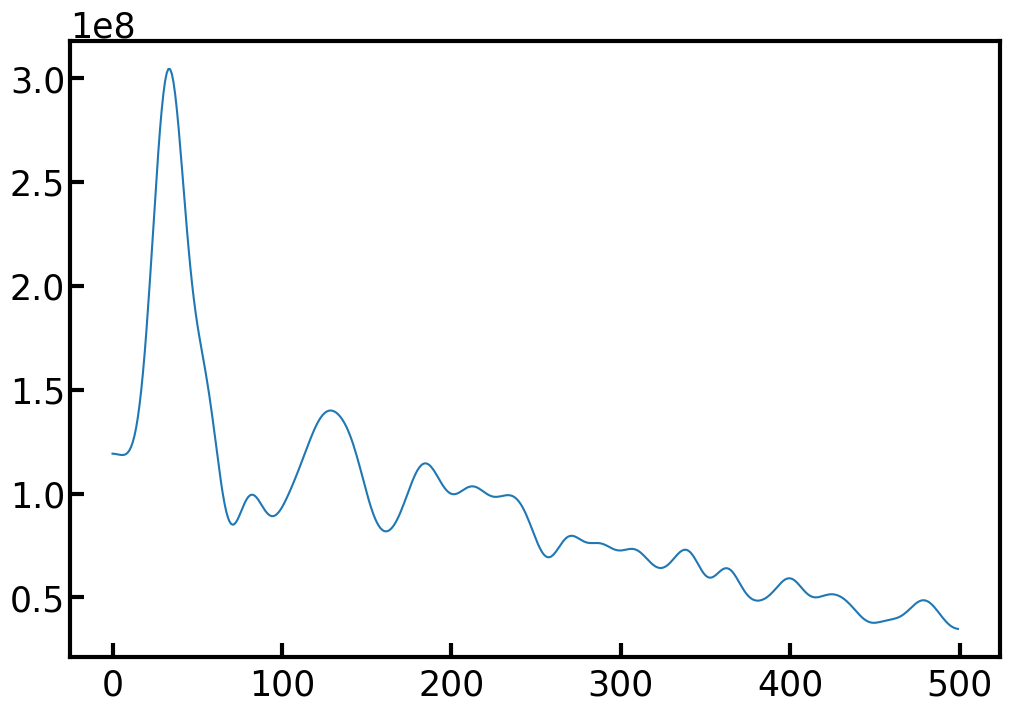

In [32]:
plt.plot(hdif,label='hdif')

In [33]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [34]:
print(binned_ells)
print(hdif_decoupled)

[ 79.5 111.5 143.5 175.5 207.5 239.5 271.5 303.5 335.5 367.5 399.5 431.5
 463.5]
[1.97685929e-08 3.98514863e-08 3.91727883e-08 3.13035530e-08
 3.45234405e-08 3.00695722e-08 2.38292688e-08 2.37519807e-08
 2.24100228e-08 1.79731730e-08 1.81596355e-08 1.51470359e-08
 1.44986949e-08]


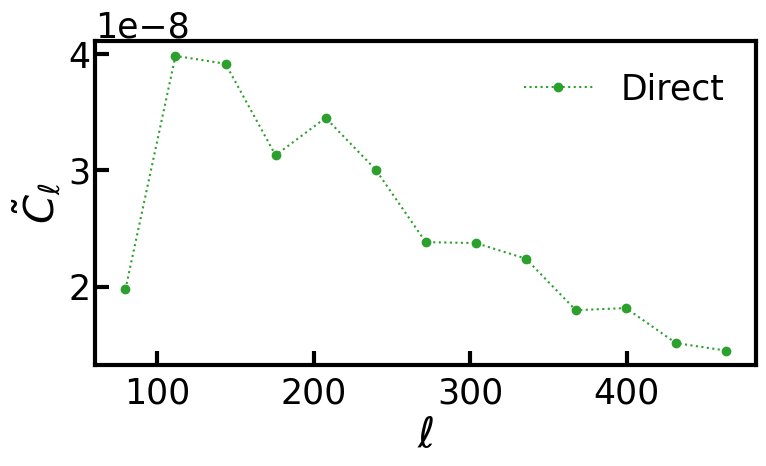

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
# clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
# ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.tight_layout()
plt.savefig('./plots/harmonic_tildeC.pdf', bbox_inches='tight')


# compute theory power spectrum 
$$C_\ell(k)  = \sum_{L \lambda}  F_{\ell L \lambda} \int\frac{dk'}{2\pi\,\bar{\chi}^2}\ P(L/\bar{\chi},k') \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k-k')\widetilde{K}_k(k-k') $$

In [36]:
from scipy.special import eval_legendre
from scipy.integrate import quad

In [42]:
# the r_ij is cancelling from the cos(theta)
# \hat{n}_j*\hat{n}_k:
nhat = np.column_stack([np.sin(tdata)*np.cos(pdata), np.sin(tdata)*np.sin(pdata), np.cos(tdata)])

In [39]:
def norm(ell):
    return (2.*ell+1.)/4./np.pi

In [45]:
qso_j = 0
#qso_k = 10
#for qso_i in range(Nskew):
# compute K_j * K_k vector for one qso_idx and *all* qso_k
kjkk = FT_mask[qso_j,:]*FT_mask

In [ ]:
lambda_idx=0

In [103]:
def int_leg(lambda_idx, k_idx=k_idx, Nskew=Nskew, FT_mask=FT_mask, nhat=nhat):
    total_sum = 0.0
    for qso_j in range(Nskew):
        # Compute K_j * K_k vector for one qso_idx and *all* qso_k
        kjkk = FT_mask[qso_j, k_idx] * FT_mask[:, k_idx]
        # Computation of cos_theta for qso_j and *all* qso_k
        cos_theta_njnk = np.dot(nhat[qso_j], nhat.T)
        # Sum over all pairs qso_j and qso_k
        total_sum += np.sum(eval_legendre(lambda_idx, cos_theta_njnk) * kjkk)
    return total_sum

In [108]:
# precompute Wigner 3j matrix 
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 2min 29s, sys: 1.28 s, total: 2min 30s
Wall time: 2min 31s


In [117]:
def F_ell_L_lambda(ell, L, lambda_):
    # Compute the prefactor
    prefactor = (2*L + 1) * (2*lambda_ + 1) / (4 * np.pi)**2
    
    # Compute the Wigner 3-j symbol
    wigner_3j_value = MD.w3j000(ell, L, lambda_)**2
    
    # Compute the final value of F_{ell L lambda}
    F_value = prefactor * wigner_3j_value
    
    return float(F_value)

In [118]:
def Power_spectrum(kh_par, ell, chi):
    kh = np.sqrt(kh_par**2 + (ell/(chi))**2)
    return GRF.plin(kh)

def Cell(l, chi_min, chi_max):
    def integrand(chi):
        # pk_chi2 = Power_spectrum(kh_par=0, ell=l, chi=chi)/(chi**2)
        pk_chi2 = Power_spectrum(kh_par=0, ell=l, chi=chi)/(chi**2)*int_leg(lambda_idx, k_idx=k_idx,)
        return pk_chi2/(2.*np.pi)
    return quad(integrand, chi_min, chi_max)[0]

#Limber's approximation
kh = np.linspace(1e-4, 10, 100)
# 2-500 in bins of 10 after 100 
ell_range = np.concatenate([np.arange(2, 100), np.arange(100, 510, 10)])
ell_range = np.concatenate([np.arange(2, 100, 10)])
#Cell = np.array([Cell(li, 0.1, 1000) for li in ell_range])

In [119]:
Cl_int = 0.
for ell_idx in ell_range:
    for L in range(10):
        for lambda_ in range(10):
            Cl_int += F_ell_L_lambda(ell_idx, L, lambda_)*Cell(ell_idx, 0.1, 1000)

AttributeError: 'PowerSpectrumGenerator' object has no attribute 'plin'

/tmp/ipykernel_711737/3681392338.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, chi_min, chi_max)[0]
